In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import pickle
from matplotlib import colors
import h5py
from tqdm import tqdm_notebook as tqdm
#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5
num_data=2000
#### ------------------------------------------------------------
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f


display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))


def Get_Bands_Matrix(N_size,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus/N_size,Fourier_minous/N_size

def Toeplitz_matrix(Fourier_plus,L):
    First_column = Fourier_plus[:L]
    First_row = np.roll(Fourier_plus,-1)[::-1][:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    to_use=Fourier_minous[:2*L-1]
    First_column=to_use[:L]
    Last_row=np.roll(to_use,-L+1)[:L]
    return hankel(First_column,Last_row)

def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L):
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))


def print_progress(total,step,num=50):
    message="["+"="*int(num*((step/total)))+" "*int(num*(1-(step/total)))+"]"
    message+="  "+str(round(step/total*100,3))+ " "+ "%"
    print(message,end="\r")
    
def get_band_of_matrix(Matrix,num_band):
    L,C=Matrix.shape
    if L!=C:
        raise ValueError("Only squared matrix can be computed")
    if num_band > 0:
        return np.array([[Matrix[i,j] for i in range(num_band,L) if i-j == num_band] for j in range(L-num_band)]).reshape(L-num_band)
    elif num_band <0:
        return np.array([[Matrix[i,j] for i in range(L) if i-j == num_band] for j in range(-num_band,L)]).reshape(L+num_band)
    else:
        return np.diagonal(Matrix)

In [3]:
f = h5py.File('Data_Fourier.h5','r')
name_minous="Fourier_minous"
name_plus="Fourier_plus"

for number in [i if i%2!=0 else i+1 for i in np.logspace(2,5,dtype=np.int,num=50)][40:]:
    print("Starting size = {}".format(number))
    F_minous=f[name_minous+"_"+str(number)].value
    F_plus=f[name_plus+"_"+str(number)].value
    total=[]
    if number < 1000:
        rango = range(3,101,2)
    else:
        rango = range(3,501,5)
    for L in tqdm(rango):
        res=[]
        for i in range(F_minous.shape[0]):
            #print(f"Cantidad fourier = {i}",end="\r")
            T_plus_H=Covariance_matrix_from_sub_sample(F_plus[i,:],F_minous[i,:],L)
            T=Toeplitz_matrix(F_plus[i,:],L)
            W_T_H=np.linalg.svd(T_plus_H,compute_uv=False)
            W_T=np.linalg.svd(T,compute_uv=False)
            result=np.sum(np.square((np.array(sorted(W_T_H))-np.array(sorted(W_T)))))/L
            res.append(result)
        total.append(np.mean(res))
        #print(f"Done L= {i}",end="\r")
    np.savetxt(f"Data_{number}.txt",total,delimiter="\t")

Starting size = 28117



Starting size = 32375



Starting size = 37275



Starting size = 42919



Starting size = 49417



Starting size = 56899



Starting size = 65513



Starting size = 75431



Starting size = 86851



Starting size = 100001


Starting size = 28117


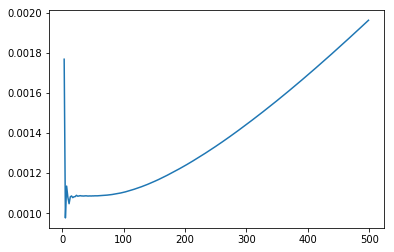

Starting size = 32375


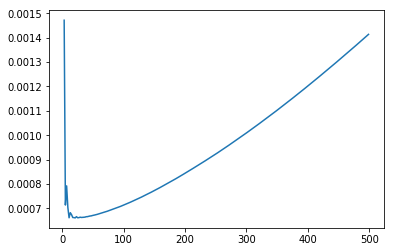

Starting size = 37275


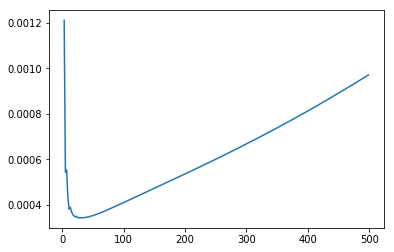

Starting size = 42919


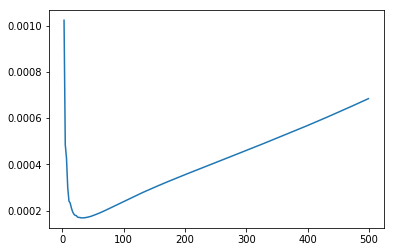

Starting size = 49417


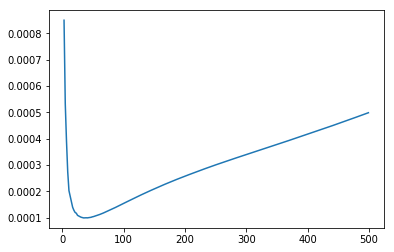

Starting size = 56899


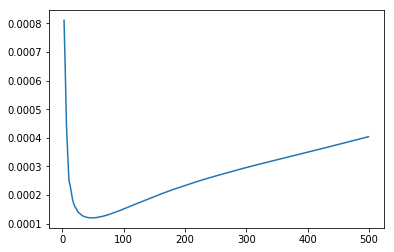

Starting size = 65513


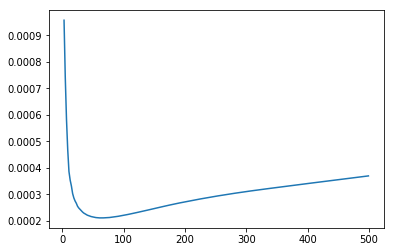

Starting size = 75431


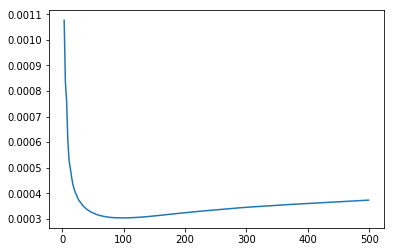

Starting size = 86851


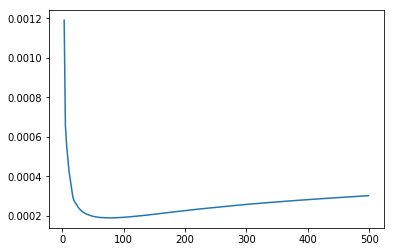

Starting size = 100001


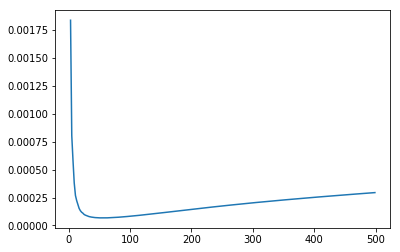

In [4]:
f = h5py.File('Data_Fourier.h5','r')
name_minous="Fourier_minous"
name_plus="Fourier_plus"

for number in [i if i%2!=0 else i+1 for i in np.logspace(2,5,dtype=np.int,num=50)][40:]:
    print("Starting size = {}".format(number))
    F_minous=f[name_minous+"_"+str(number)].value
    F_plus=f[name_plus+"_"+str(number)].value
    total=[]
    if number < 1000:
        rango = range(3,101,2)
    else:
        rango = range(3,501,2)
    for L in tqdm(rango):
        res=[]
        n=np.arange(-(L-1)/2,(L-1)/2 +1)
        for i in range(F_minous.shape[0]):
            Cov_Matrix=Covariance_matrix_from_sub_sample(F_plus[i,:],F_minous[i,:],L)
            S=np.linalg.svd(Cov_Matrix,compute_uv=False)
            S=-S+0.5
            fermi=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
            result=np.sum(np.square((np.array(sorted(S))-np.array(sorted(fermi)))))/L
            res.append(result)
        total.append(np.mean(res))
    plt.plot(rango,total)
    plt.show()